# Calculating Gene expression. 

This script calculates gene expression in raw read counts, RPKM and TPM (So we are looking at the raw reads and a normalizsed measure of gene expression) using matched samples of RNA-seq and ribosome profiling data. 

## Importing packages and defining the path

In [1]:
# Loading up the path to my tools file. 
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Loading up required packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define important paths. 
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/human/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/human/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/human/"
gtf_name = 'hg38.refGene.gtf'
mutation = 'control'
samp_num = '1'
special = ""
if os.path.isfile(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading in the data

In [4]:
# Load up the genome annotation as a list of transcript objects
gtf_reads=list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Open the read alignments, storing each dataset in a BAMGenomeArray:
my_datasets = { "ribosome_profiling" : data_path + mutation +"_RPF_" + samp_num + "_Aligned.sortedByCoord.out.bam",
                "RNA-seq"            : data_path + mutation +"_RNA_" + samp_num + "_Aligned.sortedByCoord.out.bam",
              }

my_datasets = { K : BAMGenomeArray(V) for K,V in my_datasets.items() }

In [6]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv(p_site_path + mutation +"_RPF_" + samp_num + "_Aligned.toTranscriptome.out_p-site-offsets", sep="\t")

# Map the ribosome profiling alignments to the p-site. 
my_datasets["ribosome_profiling"].set_mapping(kat.VariableThreePrimeMapFactory(p_offsets=p_offsets))

# Map the RNA sequence alignments along the entire length of each alignment. 
my_datasets["RNA-seq"].set_mapping(CenterMapFactory())

In [7]:
# we will calculate both total counts and RPKM
metrics = ("counts","rpk","lengths")

# create an empty list for each sample, region, and metric
my_data = { "%s_%s" % (SAMPLE,METRIC) : copy.deepcopy([])\
                                                  for SAMPLE in my_datasets.keys()\
                                                  for METRIC in metrics }

# add a list to our dictionary of lists to store transcript IDs
my_data["transcript_ID"] = []
my_data["gene_ID"] = []

for transcript in gtf_reads:
        
    # First, save ID of transcript we are evaluating
    my_data["transcript_ID"].append(transcript.get_name())
    my_data["gene_ID"].append(transcript.attr["gene_name"])

    # Iterate over each sample, getting the counts over each region
    for sample_name, sample_data in my_datasets.items():
        # transcript.get_counts() fetches a list of counts at each position
        # here we just want the sum
        counts = sum(transcript.get_counts(sample_data))
        rpk   = float(counts)/(transcript.length/1000)
        lengths = transcript.length
        #rpkm   = float(counts) / transcript.length * 1000 * 1e6 / sample_data.sum()
        my_data["%s_counts" % (sample_name)].append(counts)
        my_data["%s_rpk"   % (sample_name)].append(rpk)
        my_data["%s_lengths" % (sample_name)].append(lengths)
        #my_data["%s_rpkm"   % (sample_name)].append(rpkm)

In [8]:
# convert to Dataframe
df = pd.DataFrame(my_data)

## Estimating translation efficiency

In [9]:
# Calculate tpm using rpk from our new dataframe. 
for sample_name, sample_data in my_datasets.items():
    per_m_s = sum(df["%s_rpk"   % (sample_name)])/1e6
    df["%s_tpm" % (sample_name)] = (df["%s_rpk"   % (sample_name)])/per_m_s
    
# Calculate rpkm using the read counts. Work in progress.
for sample_name, sample_data in my_datasets.items():
    counts = df["%s_counts"   % (sample_name)]
    rpkm   = counts / df["%s_lengths"   % (sample_name)]*1000 * 1e6 / sum(counts)
    df["%s_rpkm" % (sample_name)] = rpkm
    
    
# Calculate translation efficiency using tpm
df["TE_tpm"] = df["ribosome_profiling_tpm"] / df["RNA-seq_tpm"]

# Calculate translation efficiency using rpkm
df["TE_rpkm"] = df["ribosome_profiling_rpkm"] / df["RNA-seq_rpkm"]

In [10]:
# Rearranging Column names to make something more readable. 
cols = ['transcript_ID', "gene_ID", 'TE_tpm','TE_rpkm','ribosome_profiling_tpm',
        'RNA-seq_tpm','ribosome_profiling_counts','RNA-seq_counts',
        'ribosome_profiling_rpkm', 'RNA-seq_rpkm', 'ribosome_profiling_rpk', 
       'RNA-seq_rpk', 'ribosome_profiling_lengths', 'RNA-seq_lengths']
df = df[cols]

In [11]:
# save the data frame.
if pre_load == False:
    df.to_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv", index=False)

In [12]:
# A line of code that quickly loads up the data if it has already been saved. 
if pre_load == True:
    df = pd.read_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv")

## Distribution of translation efficiency

In [13]:
df_clean=df[~df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]
df_interest=df_clean[(df_clean["TE_tpm"] >= 5)&(df_clean["TE_tpm"] <= 800)]

(0.0, 100.0)

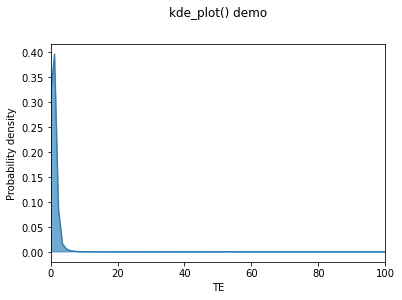

In [14]:
# plot kernel density estimates of A and B on the same axis
fig, ax = kde_plot(df_clean["TE_rpkm"],label="TE")

# make things look nice
plt.xlabel("TE")
plt.ylabel("Probability density")
plt.title("kde_plot() demo",y=1.1)
plt.xlim(0,100)

## Translation levels vs transcription levels

Text(0, 0.5, 'Translation (tpm of footprints over CDS)')

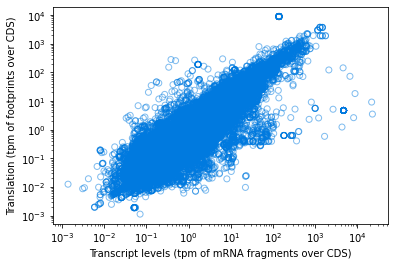

In [15]:
my_figure = plt.figure()
plt.loglog() # log-scaling makes it easier

# make a copy of dataframe for plotting
# this is because 0-values cannot be plotted in log-space,
# so we set them to a pseudo value called `MIN_VAL`

MIN_VAL = np.nan
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_tpm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_tpm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_tpm"],
            plot_df["ribosome_profiling_tpm"],
            marker="o",alpha=0.5,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (tpm of mRNA fragments over CDS)")
plt.ylabel("Translation (tpm of footprints over CDS)")

## Translation efficiency vs transcript levels.

<module 'matplotlib.pyplot' from '/home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/matplotlib/pyplot.py'>

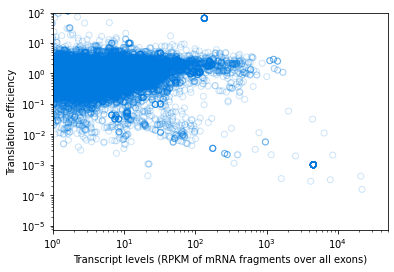

In [16]:
plt.loglog()
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_rpkm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_rpkm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_rpkm"],
            plot_df["TE_tpm"],
            marker="o",alpha=0.2,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (RPKM of mRNA fragments over all exons)")
plt.ylabel("Translation efficiency")
plt.xlim(1,plt.xlim()[1])
plt.ylim(plt.ylim()[0]/10.0,100)

plt